In [1]:
import sys
sys.path.append('/accounts/grad/zhangyunzhe2023/tlide')

from typing import List, Optional
from llama import Dialog, Llama

import os
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
import seaborn as sns

# choose any free port
os.environ.setdefault("MASTER_ADDR", "127.0.0.1")
os.environ.setdefault("MASTER_PORT", "29500")
os.environ.setdefault("RANK", "0")
os.environ.setdefault("WORLD_SIZE", "1")
os.environ.setdefault("LOCAL_RANK", "0")

# if you have a CUDA GPU, use 'nccl'; otherwise use 'gloo'
backend = "nccl" if torch.cuda.is_available() else "gloo"
if backend == "nccl":
    torch.cuda.set_device(0)

dist.init_process_group(backend=backend)

In [2]:
generator = Llama.build(
    ckpt_dir='/accounts/grad/zhangyunzhe2023/.llama/checkpoints/Llama3.2-1B',
    tokenizer_path='/accounts/grad/zhangyunzhe2023/.llama/checkpoints/Llama3.2-1B/tokenizer.model',
    max_seq_len=8192,
    max_batch_size=1,
)

tokenizer = generator.tokenizer
model = generator.model.eval()
params = generator.model.params

> initializing model parallel with size 1
> initializing ddp with size 1
> initializing pipeline with size 1


/scratch/users/zhangyunzhe2023/conda/envs/torch28/lib/python3.13/site-packages/torch/__init__.py:1264: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


Loaded in 5.79 seconds


In [3]:
from datasets import load_dataset
dataset = load_dataset('THUDM/LongBench-v2', split='train')

In [44]:
text = dataset[1]['context']
start = text.find('\n')
text = text[start+1:]

prompts: List[str] = [text]

In [5]:
prompt_tokens = [tokenizer.encode(prompts[0], bos=True, eos=False)]
bsz = 1
pad_id = tokenizer.pad_id
tokens = torch.tensor(prompt_tokens, dtype=torch.long, device="cuda")

In [11]:
def merge_kv_cache(ks, vs):
    # k, v: (N, D)
    k_merged = ks.sum(dim=0)
    k_merged_norm_sq = torch.dot(k_merged, k_merged)
    alphas = torch.mv(ks, k_merged) / k_merged_norm_sq
    alpha_var = torch.var(alphas, unbiased=False)
    v_merged = vs.mean(dim=0)
    return k_merged, alpha_var, v_merged

def softmax_modified(x, alpha_vars, n_merged):
    to_exp = x / n_merged + alpha_vars * x.square() / 2
    to_exp = to_exp - to_exp.max(dim=-1, keepdim=True).values
    approx_merged_exp = n_merged * to_exp.exp()
    score = approx_merged_exp / approx_merged_exp.sum(dim=-1, keepdim=True)
    return score

def sdpa_modified(
    xq: torch.Tensor,          # (query_seq_len, head_dim)
    keys: torch.Tensor,        # (prev_seq_len, head_dim)
    values: torch.Tensor,      # (prev_seq_len, head_dim)
    alpha_vars: Optional[torch.Tensor]=None,  # (prev_seq_len,)
    n_merged: Optional[torch.Tensor]=None,    # (prev_seq_len,)
    mask: Optional[torch.Tensor] = None  # (query_seq_len, prev_seq_len) additive bias (e.g., -inf for masked)
) -> torch.Tensor:
    """
    Scaled dot-product attention for a single head and a single batch element.

    Returns:
        Tensor of shape (query_seq_len, head_dim).
    """
    # (Tq, D) @ (D, Tk) -> (Tq, Tk)
    head_dim = xq.shape[-1]
    scores = (xq @ keys.transpose(0, 1)) / math.sqrt(head_dim)

    if mask is not None:
        # mask is additive; same dtype broadcast rules as in your batched version
        # expected shape: (Tq, Tk) or broadcastable to it
        scores = scores + mask

    # Compute attention and bring back to original dtype
    if alpha_vars is not None and n_merged is not None:
        attn = softmax_modified(scores.float(), alpha_vars, n_merged).to(xq.dtype)
    else:
        attn = F.softmax(scores, dim=-1)

    # (Tq, Tk) @ (Tk, D) -> (Tq, D)
    out = attn @ values
    return out

In [35]:
def eval_kv_cache_compress(
    cache_k: torch.Tensor,
    cache_v: torch.Tensor,
    xq: torch.Tensor,
    merge_budget: int
):
    cos_sim = nn.CosineSimilarity(dim=1, eps=1e-8)
    s = cos_sim(cache_k[:-1], cache_k[1:])
    break_points = torch.argsort(s)[:merge_budget-1].sort()[0]
    break_points = break_points + 1
    break_points = break_points.cpu().numpy().tolist()
    break_points.insert(0, 0)
    break_points.append(1000000)

    compressed_cache_k = []
    compressed_cache_v = []
    alpha_vars = []
    n_merged = []
    compressed_cache_k_baseline = []
    compressed_cache_v_baseline = []
    for i in range(len(break_points) - 1):
        cache_k_chunk = cache_k[break_points[i]:break_points[i + 1]]
        cache_v_chunk = cache_v[break_points[i]:break_points[i + 1]]
        k_merged, alpha_var, v_merged = merge_kv_cache(cache_k_chunk, cache_v_chunk)
        compressed_cache_k.append(k_merged)
        compressed_cache_v.append(v_merged)
        alpha_vars.append(alpha_var)
        n_merged.append(cache_k_chunk.size(0))

        # Baseline merging: plain average
        compressed_cache_k_baseline.append(cache_k_chunk.mean(dim=0))
        compressed_cache_v_baseline.append(cache_v_chunk.mean(dim=0))

    compressed_cache_k = torch.stack(compressed_cache_k)
    compressed_cache_v = torch.stack(compressed_cache_v)
    alpha_vars = torch.stack(alpha_vars)
    n_merged = torch.tensor(n_merged)

    compressed_cache_k_baseline = torch.stack(compressed_cache_k_baseline)
    compressed_cache_v_baseline = torch.stack(compressed_cache_v_baseline)

    merged_errors = []
    merged_baseline_errors = []
    for i in range(4):
        result_merged = sdpa_modified(xq[:, i], compressed_cache_k, compressed_cache_v, alpha_vars, n_merged)
        result_merged_baseline = sdpa_modified(xq[:, i], compressed_cache_k_baseline, compressed_cache_v_baseline)
        result_exact = sdpa_modified(xq[:, i], cache_k, cache_v)

        result_exact_norm = result_exact.square().sum().sqrt()
        merged_error = (result_merged - result_exact).square().sum().sqrt() / result_exact_norm
        merged_baseline_error = (result_merged_baseline - result_exact).square().sum().sqrt() / result_exact_norm

        merged_errors.append(merged_error)
        merged_baseline_errors.append(merged_baseline_error)
    return torch.tensor(merged_errors), torch.tensor(merged_baseline_errors)

In [14]:
_ = model.forward(tokens[:, 0:8192], 0, return_last_hidden=True)

In [41]:
eval_layer = 4
eval_head = 1
eval_pos = 4095

cache_k = model.layers[eval_layer].attention.cache_k[0, :eval_pos+1, eval_head]
cache_v = model.layers[eval_layer].attention.cache_v[0, :eval_pos+1, eval_head]

xq = model.layers[eval_layer].attention.cache_q[0, eval_pos:eval_pos+1, eval_head*4:eval_head*4+4]

In [43]:
eval_kv_cache_compress(cache_k, cache_v, xq, merge_budget=2000)

(tensor([0.3468, 0.4547, 0.2718, 0.3882]),
 tensor([0.6129, 0.6221, 0.5929, 0.6744]))

In [41]:
def pairwise_cos_sim(x):
    x1 = x.unsqueeze(1)
    x2 = x.unsqueeze(0)
    cos_sim = nn.CosineSimilarity(dim=2, eps=1e-8)
    return cos_sim(x1, x2)

def pairwise_l_norm(x, ord=2):
    x1 = x.unsqueeze(1)
    x2 = x.unsqueeze(0)
    l_norm = torch.linalg.vector_norm(x1 - x2, ord=ord, dim=-1)
    return l_norm

<Axes: >

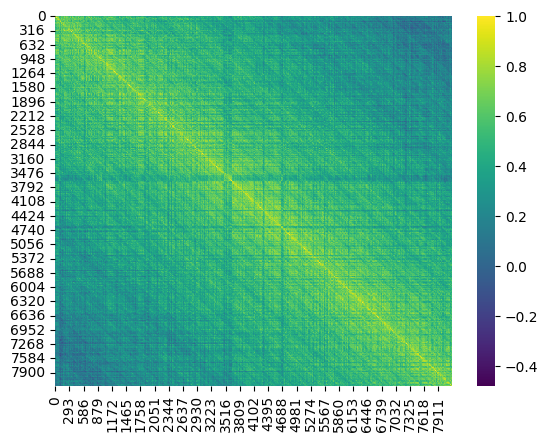

In [10]:
sim = pairwise_cos_sim(x.cpu())
sns.heatmap(sim.detach().cpu().numpy(), cmap="viridis")

<Axes: >

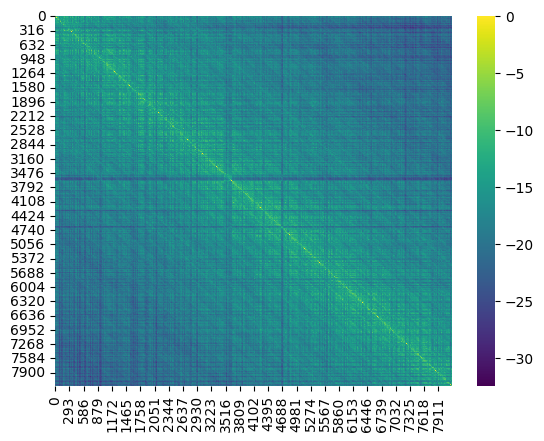

In [42]:
sim = pairwise_l_norm(x)
sns.heatmap(-sim.detach().cpu().numpy(), cmap="viridis")

<Axes: >

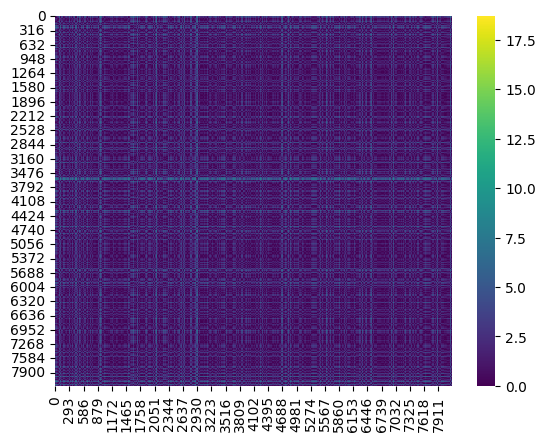

In [46]:
sns.heatmap(pairwise_l_norm(x.square().sum(dim=1).sqrt().unsqueeze((-1))).detach().cpu().numpy(), cmap="viridis")